In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import random
from Strategy import *

In [2]:
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import SparsePCA, PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, uniform, randint

In [97]:
df = pd.read_csv("Y:\\Dropbox\\Dropbox (MIT)\\Robinhood Trading\\Stock Data\\broader_stock.csv")
df = df.iloc[:-1]

In [96]:
sp500_txt = open('sp_ticker_list.txt', 'r')
sp500_con = [line.rstrip('\n') for line in sp500_txt]

for tick in df.columns[1:]:
    initpos = df[tick].first_valid_index()
    if df[tick].iloc[initpos:].isna().sum() > 1:
        df.drop(tick, axis=1, inplace=True)

KeyboardInterrupt: 

In [84]:
for tick in df.columns[1:]:
    initpos = df[tick].first_valid_index()
    if df[tick].iloc[initpos:].isna().sum() != 0:
        print(tick)

<AxesSubplot:>

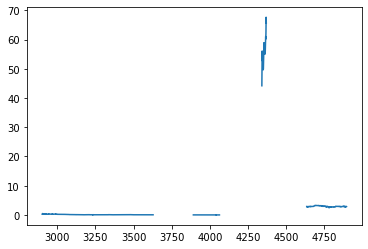

In [95]:
df['AAG_Open'].plot()

In [45]:
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(['Date'], axis=1, inplace=True)
pct_df = df.pct_change().shift(1).iloc[2:]

pct_wk = (1+pct_df).resample('W').prod() - 1
rebal_date = random.sample(list(pct_wk.index)[200:], 5)

In [73]:
err_tick = []

for tick in pct_wk.columns:
    initpos = pct_wk.index.get_loc(pct_wk[tick].first_valid_index())
    if pct_wk[tick].iloc[initpos:].isna().sum() != 0:
        if tick.split("_")[1] != 'Volume':
            err_tick.append(tick.split("_")[0])
            
err_tick = list(set(err_tick))
valid_col = [c for c in pct_wk.columns if c.split("_")[0] not in err_tick]
pct_wk = pct_wk[valid_col]

In [76]:
decom_method = [SparsePCA(n_jobs=-1), PCA()]

param_grid = {
    'n_estimators': randint(low=5,high=30),
    'max_depth': randint(low=5,high=20),
    'min_samples_split': randint(low=10,high=50),
    'ccp_alpha': expon(scale=.1)
}

estimator = [GradientBoostingClassifier(), RandomForestClassifier(n_jobs=-1)]

In [77]:
%%time

res = {}

for d in rebal_date:
    # Partialling out R_m
    residual = []

    d_pos = pct_wk.index.get_loc(d)
    history = pct_wk.iloc[d_pos-200:d_pos]

    rm = history['SPY_Open']
    for tick in history.columns[::3]:
        ri = history[tick]
        if tick.split("_")[0] in sp500_con and ri.iloc[0] != 0:
            temp = pd.concat([ri, rm], axis=1).dropna()
            y = temp[temp.columns[0]].values
            X = temp[temp.columns[1:]].values

            reg = ElasticNetCV(cv=5, n_jobs=-1).fit(X, y)
            yhat = reg.predict(X)
            eps = y - yhat
            residual.append(eps)
    RES = np.column_stack(residual)
    print(RES.shape)
    
    # decomposition
    decom_dict = {}

    for method in decom_method:
        decom = method.fit_transform(RES)
        exp_var = np.var(decom, axis=0, ddof=1) / sum(np.var(decom, axis=0, ddof=1))
        ttl_var = float()
        comp = 0
        while ttl_var <= 0.9:
            ttl_var += exp_var[comp]
            comp += 1
        print(comp)
        decom_dict[method] = decom[:, :comp]
    
    # prediction modeling
    ttl_acc = {}

    for tick in random.sample(list(history.columns[::3]), 5):
        candidate_models = []
        Y = history[tick].shift(-1).dropna().values
        if Y[0] != 0:
            Y = (Y > 0).astype(int)

            for method in list(decom_dict):
                feature_X = decom_dict[method][:-1,]
                for est in estimator:
                    clf = RandomizedSearchCV(est, param_grid)
                    search = clf.fit(feature_X, Y)
                    candidate_models.append(search.best_estimator_)
            pred_list = []
            for i, method in enumerate(list(decom_dict)):
                test_X = decom_dict[method][-1,].reshape(1, -1)
                for model in candidate_models[i*2:i*2+2]:
                    y_pred = model.predict(test_X)[0]
                    pred_list.append(y_pred)

            y_true = (history[tick].iloc[-1] > 0).astype(int)
            acc_result = []
            for pred in pred_list:
                acc_result.append((pred == y_true).astype(int))

            ttl_acc[tick] = acc_result
            print(tick)
    
    res[d] = ttl_acc
    print(d)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [78]:
tick

'AAG_Open'

In [69]:
err_tick

['PPE', 'AVZ', 'TERX', 'CDB', 'SPC', 'SAI', 'MXM', 'PA']

In [17]:
np.isnan(X).sum()

0

<AxesSubplot:xlabel='Date'>

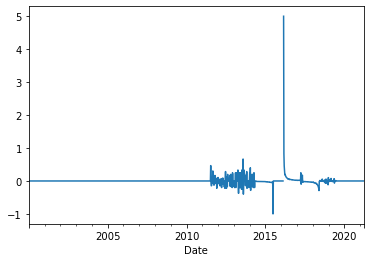

In [80]:
pct_wk['AAG_Open'].plot()

<AxesSubplot:xlabel='Date'>

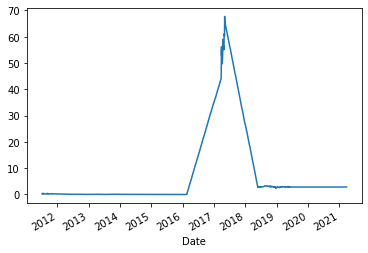

In [82]:
df['AAG_Open'].plot()

### Partial out $R_m$ from individual return series
Using only the past 200 observations

In [141]:
%%time

d = rebal_date[0]
residual = []

d_pos = pct_wk.index.get_loc(d)
history = pct_wk.iloc[d_pos-200:d_pos]

rm = history['SPY_Open']
for tick in history.columns[::3]:
    ri = history[tick]
    if tick.split("_")[0] in sp500_con and ri.iloc[0] != 0:
        temp = pd.concat([ri, rm], axis=1).dropna()
        y = temp[temp.columns[0]].values
        X = temp[temp.columns[1:]].values

        reg = ElasticNetCV(cv=5, n_jobs=-1).fit(X, y)
        yhat = reg.predict(X)
        eps = y - yhat
        residual.append(eps)
    

Wall time: 51.2 s


In [146]:
RES = np.column_stack(residual)
print(RES.shape)

(200, 467)


### Use different dimension reduction techniques to combine the features

In [164]:
decom_dict = {}

for method in decom_method:
    decom = method.fit_transform(RES)
    exp_var = np.var(decom, axis=0, ddof=1) / sum(np.var(decom, axis=0, ddof=1))
    ttl_var = float()
    comp = 0
    while ttl_var <= 0.9:
        ttl_var += exp_var[comp]
        comp += 1
    print(comp)
    decom_dict[method] = decom[:, :comp]

### Ensemble method for Prediction

In [168]:
%%time

ttl_acc = {}

for tick in random.sample(list(history.columns[::3]), 5):
    candidate_models = []
    Y = history[tick].shift(-1).dropna().values
    if Y[0] != 0:
        Y = (Y > 0).astype(int)

        for method in list(decom_dict):
            feature_X = decom_dict[method][:-1,]
            for est in estimator:
                clf = RandomizedSearchCV(est, param_grid)
                search = clf.fit(feature_X, Y)
                candidate_models.append(search.best_estimator_)
                print("method:", method, "estimator:", clf.best_estimator_, clf.best_score_)

        pred_list = []
        for i, method in enumerate(list(decom_dict)):
            test_X = decom_dict[method][-1,].reshape(1, -1)
            for model in candidate_models[i*2:i*2+2]:
                y_pred = model.predict(test_X)[0]
                pred_list.append(y_pred)

        y_true = (history[tick].iloc[-1] > 0).astype(int)
        acc_result = []
        for pred in pred_list:
            acc_result.append((pred == y_true).astype(int))
        
        ttl_acc[tick] = acc_result
        print(np.mean(acc_result))
        print(tick)

method: SparsePCA(n_jobs=-1) estimator: GradientBoostingClassifier(ccp_alpha=0.047679505854015064, max_depth=9,
                           min_samples_split=11, n_estimators=21) 0.5326923076923077
method: SparsePCA(n_jobs=-1) estimator: RandomForestClassifier(ccp_alpha=0.056986952894195475, max_depth=19,
                       min_samples_split=42, n_estimators=26, n_jobs=-1) 0.5326923076923077
method: PCA() estimator: GradientBoostingClassifier(ccp_alpha=0.011167839958796095, max_depth=19,
                           min_samples_split=26, n_estimators=7) 0.5326923076923077
method: PCA() estimator: RandomForestClassifier(ccp_alpha=0.24095352670511527, max_depth=12,
                       min_samples_split=24, n_estimators=13, n_jobs=-1) 0.5326923076923077
1.0
CCI_Open
method: SparsePCA(n_jobs=-1) estimator: GradientBoostingClassifier(ccp_alpha=0.123717918632612, max_depth=16,
                           min_samples_split=32, n_estimators=11) 0.5175641025641025
method: SparsePCA(n_jobs=-1

In [160]:
np.mean(ttl_acc)

0.3541666666666667

In [169]:
ttl_acc

{'CCI_Open': [1, 1, 1, 1],
 'CHRW_Open': [0, 1, 1, 0],
 'HCSG_Open': [0, 0, 0, 1],
 'CMTL_Open': [0, 1, 1, 0],
 'WWW_Open': [1, 1, 1, 1]}